In [1]:
import pyvista as pv
import vtk
import numpy as np

In [2]:
from utils import load_sample_mesh
mesh = load_sample_mesh()
mesh.plot()

Widget(value='<iframe src="http://localhost:44301/index.html?ui=P_0x7fb569037e50_0&reconnect=auto" class="pyvi…

In [3]:
from utils import pv_to_trimesh
# mesh를 Trimesh로 변환
tri_mesh = pv_to_trimesh(mesh)
tri_mesh.show()

# 이제 trimesh의 signed_distance() 함수 사용 가능
# 예시:
# distances = tri_mesh.signed_distance(points)

In [4]:
import trimesh
help(trimesh.proximity.signed_distance)

Help on function signed_distance in module trimesh.proximity:

signed_distance(mesh, points)
    Find the signed distance from a mesh to a list of points.
    
    * Points OUTSIDE the mesh will have NEGATIVE distance
    * Points within tol.merge of the surface will have POSITIVE distance
    * Points INSIDE the mesh will have POSITIVE distance
    
    Parameters
    -----------
    mesh : trimesh.Trimesh
      Mesh to query.
    points : (n, 3) float
      Points in space
    
    Returns
    ----------
    signed_distance : (n,) float
      Signed distance from point to mesh



In [5]:
tri_mesh = pv_to_trimesh(mesh)

bounds = tri_mesh.bounds
# NOTE: resolution 값이 너무 크면 메모리 부족으로 커널이 죽음
resolution = 25

margin = 0.01
x_vals = np.linspace(bounds[0][0] - margin, bounds[1][0] + margin, resolution)
y_vals = np.linspace(bounds[0][1] - margin, bounds[1][1] + margin, resolution)
z_vals = np.linspace(bounds[0][2] - margin, bounds[1][2] + margin, resolution)

X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')
grid_points = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
grid = pv.ImageData(dimensions=(resolution, resolution, resolution))
grid.origin = (bounds[0][0], bounds[0][1], bounds[0][2])
grid.spacing = (x_vals[1] - x_vals[0], y_vals[1] - y_vals[0], z_vals[1] - z_vals[0])
grid.point_data['points'] = grid_points
grid.set_active_scalars('points')
grid.plot()


Widget(value='<iframe src="http://localhost:44301/index.html?ui=P_0x7fb5352c7040_1&reconnect=auto" class="pyvi…

In [6]:
distances = trimesh.proximity.signed_distance(tri_mesh, grid_points)
distances

array([-28.9172255 , -28.65880152, -28.55687122, ..., -48.86921785,
       -51.52789812, -54.189209  ], shape=(15625,))

In [7]:
grid['distances'] = distances
grid.set_active_scalars('distances')
grid.plot()


Widget(value='<iframe src="http://localhost:44301/index.html?ui=P_0x7fb5351e4130_2&reconnect=auto" class="pyvi…

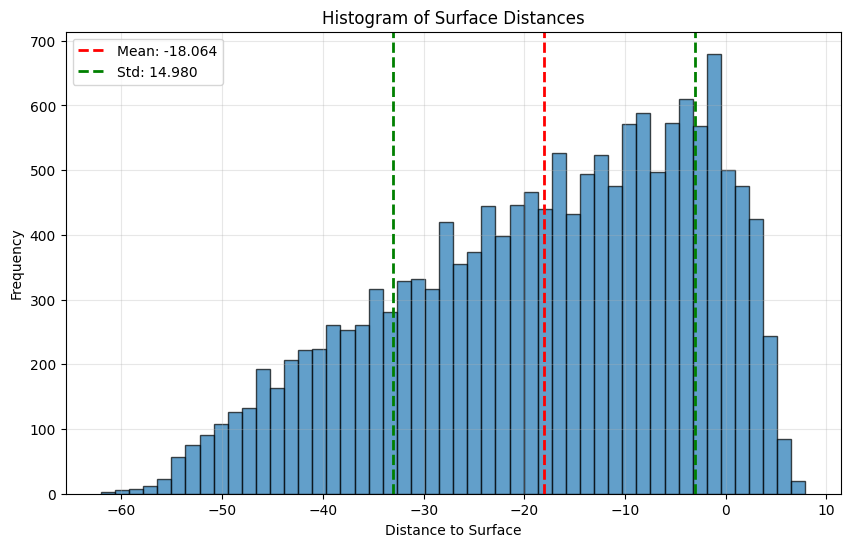

Mean distance: -18.064
Standard deviation: 14.980
Min distance: -62.044
Max distance: 7.910


In [8]:
from utils import plot_histogram
plot_histogram(distances)

In [9]:
# distance 부호 반전
distances = -distances
grid['distances'] = distances
grid.set_active_scalars('distances')
grid.plot()

Widget(value='<iframe src="http://localhost:44301/index.html?ui=P_0x7fb4bdb66a40_3&reconnect=auto" class="pyvi…

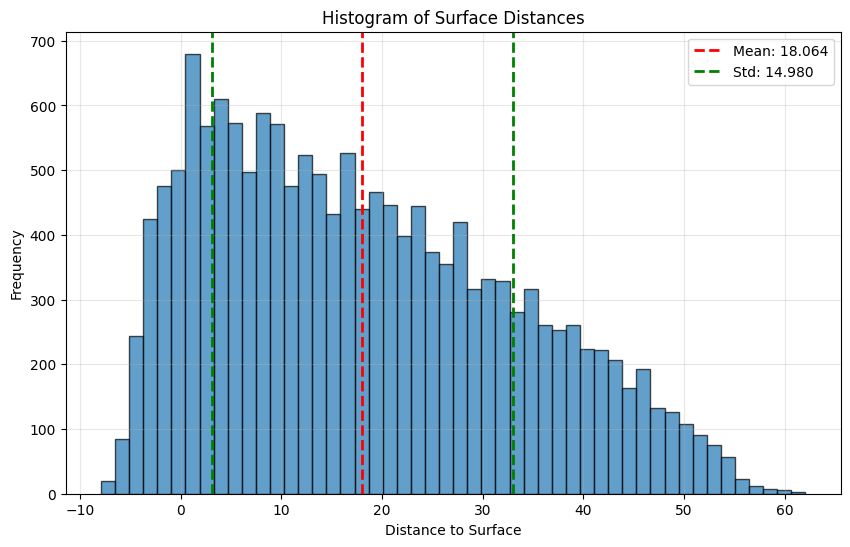

Mean distance: 18.064
Standard deviation: 14.980
Min distance: -7.910
Max distance: 62.044


In [10]:
plot_histogram(distances)

In [11]:
from skimage.measure import marching_cubes
distances_3d = distances.reshape(resolution, resolution, resolution)
results = marching_cubes(distances_3d, level=0, spacing=(x_vals[1]-x_vals[0], y_vals[1]-y_vals[0], z_vals[1]-z_vals[0]))
results


(array([[  4.14506462,  74.42532918,  35.22595294],
        [  4.46000749,  73.54468263,  35.22595294],
        [  4.46000749,  74.42532918,  34.66742541],
        ...,
        [105.01308845, 171.17825711,   5.41937738],
        [104.94129965, 171.17825711,   8.12906606],
        [103.39929099, 171.17825711,  10.83875475]], shape=(2487, 3)),
 array([[   2,    1,    0],
        [   4,    3,    0],
        [   4,    0,    1],
        ...,
        [2485, 2473, 2474],
        [2485, 2474, 2486],
        [2486, 2474, 2470]], shape=(5006, 3), dtype=int32),
 array([[ 0.9454479 , -0.15589488,  0.28605068],
        [ 0.75077647,  0.58826226,  0.30046993],
        [ 0.7746437 , -0.5523516 ,  0.3079527 ],
        ...,
        [-0.7534012 , -0.65433204,  0.06508587],
        [-0.7255609 , -0.6798494 , -0.10661227],
        [-0.66229284, -0.6019669 , -0.44609866]],
       shape=(2487, 3), dtype=float32),
 array([8.732714 , 6.1470404, 8.850789 , ..., 8.542944 , 8.817947 ,
        8.817947 ], shape=(

In [12]:
reconstructed_mesh = trimesh.Trimesh(results[0], results[1])
# 만약 distance 부호 반전을 하지 않았다면 여기서 normal 벡터를 반전시켜야 함(reconstructed_mesh.invert())
reconstructed_mesh.show()